===== 1. 데이터 로드 및 변수 분리 =====
전체 데이터 크기: (3575, 30)
범주형 변수: 3개
숫자형 변수: 25개

===== 2. 전처리 정의 및 데이터 분할 =====
훈련 데이터: (2860, 28)
테스트 데이터: (715, 28)
테스트 세트 클래스 분포:
폐업여부
0    0.973427
1    0.026573
Name: proportion, dtype: float64

===== 3. 모델 파이프라인 구축 및 학습 =====
모델 학습 완료.

===== 4. 성능 평가 (Test Set) =====
              precision    recall  f1-score   support

       운영(0)       0.97      1.00      0.99       696
       폐업(1)       0.50      0.05      0.10        19

    accuracy                           0.97       715
   macro avg       0.74      0.53      0.54       715
weighted avg       0.96      0.97      0.96       715

최종 폐업(1) 재현율(Recall): 0.0526


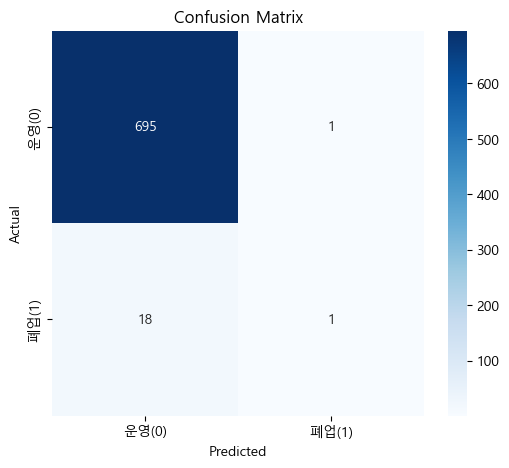


===== 5. 변수 중요도 분석 =====
상위 30개 변수 중요도:
                           Feature  Importance
59          cat__영업기간_구간_4. 장기/쇠퇴기    0.074512
0                 num__매출구간_단기_변화율    0.059783
2             num__23_24_유니크고객수_변화    0.052361
1                 num__매출구간_장기_변화율    0.042175
58          cat__영업기간_구간_3. 성장/성숙기    0.040949
7      num__23_24_동일 업종 매출건수 비율_변화    0.036606
3      num__23_24_동일 업종 매출금액 비율_변화    0.033703
4              num__장기_신규 고객 비중_변화    0.032175
14       num__단기_남성 60대이상 고객 비중_변화    0.031152
10         num__단기_남성 50대 고객 비중_변화    0.030743
40                      cat__상권_성수    0.027308
16        num__단기_유동인구 이용 고객 비율_변화    0.026748
17         num__단기_남성 40대 고객 비중_변화    0.026681
13  num__23_24_동일 업종 내 매출 순위 비율_변화    0.026274
5          num__단기_여성 40대 고객 비중_변화    0.025728
11            num__단기_재방문 고객 비중_변화    0.024231
6           num__단기_거주 이용 고객 비율_변화    0.023685
8        num__장기_남성 60대이상 고객 비중_변화    0.023334
15       num__장기_남성 20대이하 고객 비중_변화    0.023110
19                n

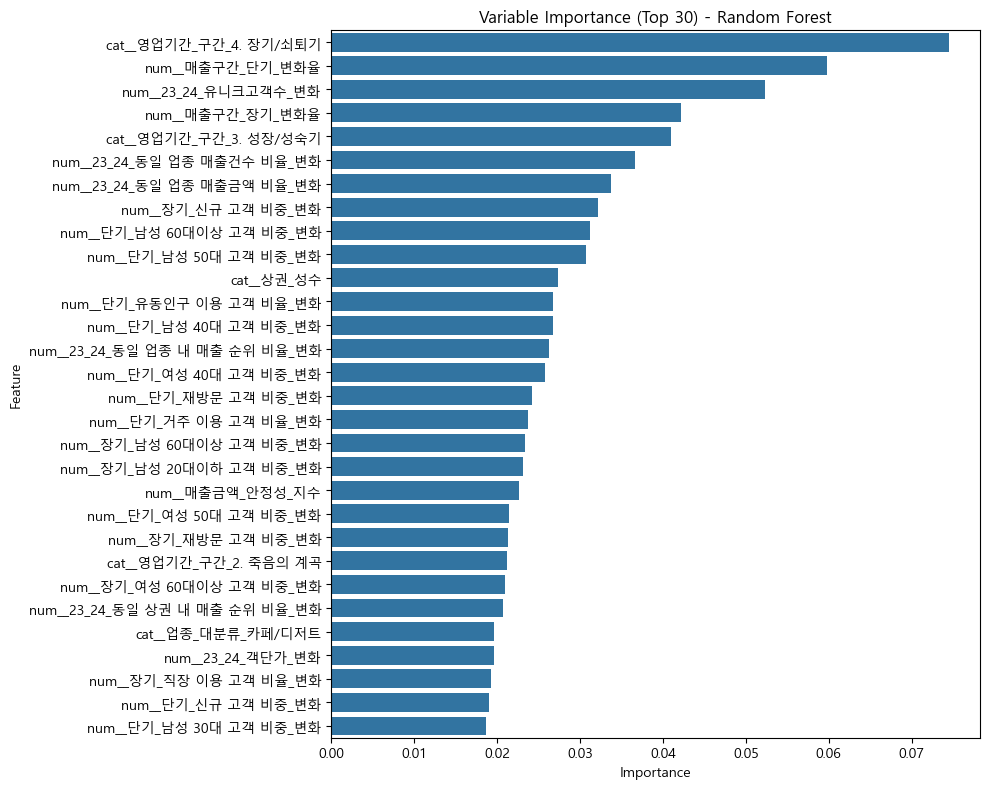

모든 분석 프로세스 완료.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn & Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from lightgbm import LGBMClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 환경 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# 1. 데이터 로드 및 변수 분리
# -----------------------------------------------------------------------------
print("===== 1. 데이터 로드 및 변수 분리 =====")
df = pd.read_csv('./data/real_final_data.csv', encoding='utf-8-sig')

# 독립변수(X)와 종속변수(y) 분리
X = df.drop(columns=['폐업여부', '가맹점구분번호'], errors='ignore')
y = df['폐업여부']

# 변수 타입 식별
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print(f"전체 데이터 크기: {df.shape}")
print(f"범주형 변수: {len(categorical_features)}개")
print(f"숫자형 변수: {len(numerical_features)}개")

# -----------------------------------------------------------------------------
# 2. 전처리 파이프라인 및 데이터 분할
# -----------------------------------------------------------------------------
print("\n===== 2. 전처리 정의 및 데이터 분할 =====")

# 전처리 정의: 숫자형(스케일링), 범주형(원-핫 인코딩)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

# 훈련/테스트 데이터 분할 (층화 추출)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"훈련 데이터: {X_train.shape}")
print(f"테스트 데이터: {X_test.shape}")
print(f"테스트 세트 클래스 분포:\n{y_test.value_counts(normalize=True)}")

# -----------------------------------------------------------------------------
# 3. 모델 파이프라인 구축 및 학습
# -----------------------------------------------------------------------------
print("\n===== 3. 모델 파이프라인 구축 및 학습 =====")

# 개별 모델 정의
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
lgbm_clf = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

# 앙상블 모델 정의 (Hard Voting)
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('lgbm', lgbm_clf)],
    voting='hard'
)

# 최종 파이프라인 (전처리 -> SMOTE -> 앙상블)
pipeline = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', voting_clf)
])

# 모델 학습
pipeline.fit(X_train, y_train)
print("모델 학습 완료.")

# -----------------------------------------------------------------------------
# 4. 성능 평가
# -----------------------------------------------------------------------------
print("\n===== 4. 성능 평가 (Test Set) =====")

# 예측 수행
y_pred = pipeline.predict(X_test)

# 평가 지표 출력
print(classification_report(y_test, y_pred, target_names=['운영(0)', '폐업(1)']))
recall_val = recall_score(y_test, y_pred, pos_label=1)
print(f"최종 폐업(1) 재현율(Recall): {recall_val:.4f}")

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['운영(0)', '폐업(1)'], yticklabels=['운영(0)', '폐업(1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# -----------------------------------------------------------------------------
# 5. 변수 중요도 분석 (RandomForest 기반)
# -----------------------------------------------------------------------------
print("\n===== 5. 변수 중요도 분석 =====")

# 파이프라인 구성 요소 추출
final_classifier = pipeline.named_steps['classifier']
final_preprocessor = pipeline.named_steps['preprocessing']

# 앙상블 내부의 RandomForest 모델 추출
rf_model = final_classifier.named_estimators_['rf']
importances = rf_model.feature_importances_

# 전처리 후의 피처 이름 추출
try:
    feature_names = final_preprocessor.get_feature_names_out()
except AttributeError:
    # 구버전 호환용 로직
    ohe_names = final_preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    feature_names = numerical_features + list(ohe_names)

# 중요도 데이터프레임 생성
if len(importances) == len(feature_names):
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    imp_df = imp_df.sort_values(by='Importance', ascending=False)

    print("상위 30개 변수 중요도:")
    print(imp_df.head(30))

    # 시각화
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=imp_df.head(30))
    plt.title('Variable Importance (Top 30) - Random Forest')
    plt.tight_layout()
    plt.show()
else:
    print("경고: 피처 이름과 중요도 배열의 길이가 일치하지 않아 시각화를 생략합니다.")
    print(f"Feature Names: {len(feature_names)}, Importances: {len(importances)}")

print("모든 분석 프로세스 완료.")

===== 1. 데이터 로드 및 변수 분리 =====
전체 데이터 크기: (3575, 30)
 - 범주형 변수: 3개
 - 숫자형 변수: 25개

===== 2. 학습/테스트 데이터 분할 =====
학습 데이터 형태: (2860, 28)
테스트 데이터 형태: (715, 28)
테스트 데이터 클래스 분포:
폐업여부
0    0.973427
1    0.026573
Name: proportion, dtype: float64

===== 3. 파이프라인 구축 및 학습 =====
모델 학습 완료.

===== 4. 임계값(Threshold) 최적화 =====
최적 임계값: 0.01
 - 해당 임계값의 재현율(Recall): 1.0000
 - 해당 임계값의 F1-Score: 0.0571


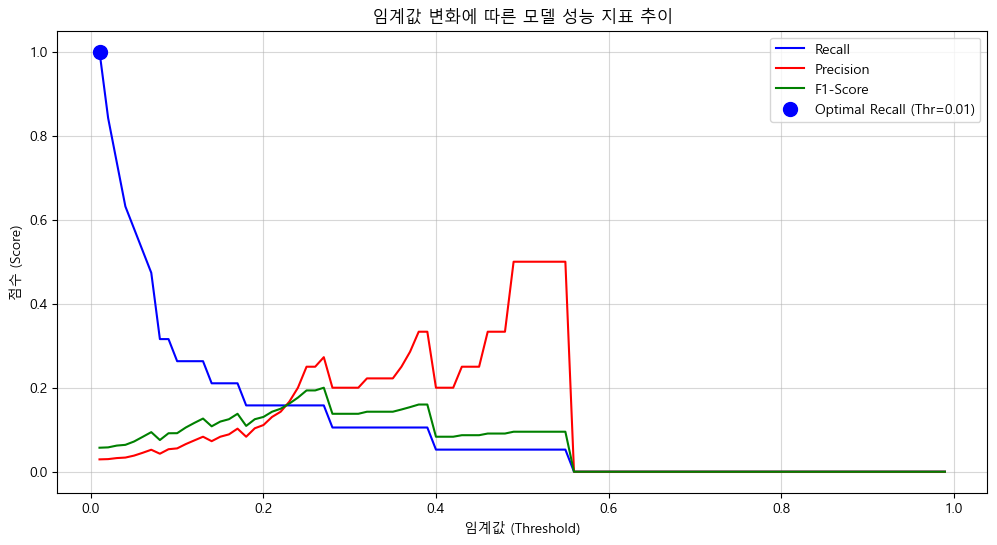


===== 5. 최종 모델 평가 (Threshold=0.01) =====
Classification Report:
              precision    recall  f1-score   support

       운영(0)       1.00      0.10      0.18       696
       폐업(1)       0.03      1.00      0.06        19

    accuracy                           0.12       715
   macro avg       0.51      0.55      0.12       715
weighted avg       0.97      0.12      0.18       715



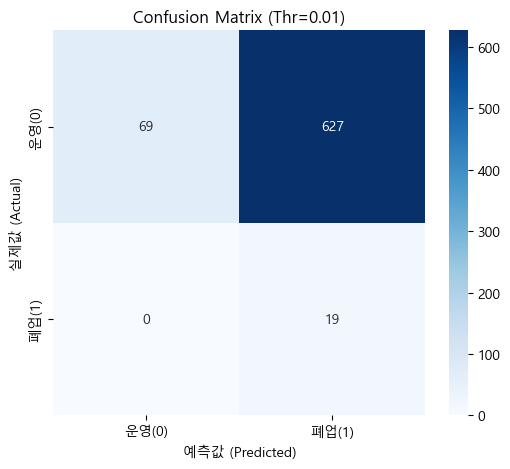

최종 성능 지표:
 - 재현율 (Recall): 1.0000
 - 정밀도 (Precision): 0.0294
 - F1-Score: 0.0571


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn 및 모델링 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
from lightgbm import LGBMClassifier

# 불균형 데이터 처리 라이브러리
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 환경 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')

# -----------------------------------------------------------------------------
# 1. 데이터 로드 및 변수 분리
# -----------------------------------------------------------------------------
print("===== 1. 데이터 로드 및 변수 분리 =====")
# 데이터 로드
df = pd.read_csv('./data/real_final_data.csv', encoding='utf-8-sig')

# 독립변수(X)와 종속변수(y) 분리
# 분석에 불필요한 식별자 컬럼 제거
X = df.drop(columns=['폐업여부', '가맹점구분번호'], errors='ignore')
y = df['폐업여부']

# 변수 타입 식별 (전처리 방식 구분을 위함)
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print(f"전체 데이터 크기: {df.shape}")
print(f" - 범주형 변수: {len(categorical_features)}개")
print(f" - 숫자형 변수: {len(numerical_features)}개")

# -----------------------------------------------------------------------------
# 2. 학습/테스트 데이터 분할
# -----------------------------------------------------------------------------
print("\n===== 2. 학습/테스트 데이터 분할 =====")
# 층화 추출(Stratified Sampling)을 통해 클래스 비율 유지
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"학습 데이터 형태: {X_train.shape}")
print(f"테스트 데이터 형태: {X_test.shape}")
print(f"테스트 데이터 클래스 분포:\n{y_test.value_counts(normalize=True)}")

# -----------------------------------------------------------------------------
# 3. 파이프라인 구축 (전처리 + SMOTE + 앙상블 모델)
# -----------------------------------------------------------------------------
print("\n===== 3. 파이프라인 구축 및 학습 =====")

# 3-1. 전처리 파이프라인 정의
# 숫자형: 표준화(StandardScaler), 범주형: 원-핫 인코딩(OneHotEncoder)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

# 3-2. 개별 모델 정의
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
lgbm_clf = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

# 3-3. 앙상블 모델 정의 (Soft Voting)
# 확률 기반 예측을 위해 soft voting 사용
voting_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('lgbm', lgbm_clf)],
    voting='soft'
)

# 3-4. 최종 파이프라인 구성 (전처리 -> 오버샘플링 -> 모델)
# SMOTE는 학습 데이터에만 적용됨
pipeline = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', voting_clf)
])

# 모델 학습
pipeline.fit(X_train, y_train)
print("모델 학습 완료.")

# -----------------------------------------------------------------------------
# 4. 임계값(Threshold) 최적화
# -----------------------------------------------------------------------------
print("\n===== 4. 임계값(Threshold) 최적화 =====")

# 테스트 데이터에 대한 폐업 확률 예측
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# 임계값 후보군 설정 (0.01 ~ 0.99)
thresholds = np.arange(0.01, 1.0, 0.01)

recall_scores = []
precision_scores = []
f1_scores = []

# 각 임계값에 따른 성능 지표 계산
for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    
    recall_scores.append(recall_score(y_test, y_pred_custom, pos_label=1, zero_division=0))
    precision_scores.append(precision_score(y_test, y_pred_custom, pos_label=1, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred_custom, pos_label=1, zero_division=0))

# 재현율(Recall)이 최대가 되는 최적 임계값 탐색
best_idx = np.argmax(recall_scores)
best_threshold = thresholds[best_idx]
best_recall = recall_scores[best_idx]
best_f1_at_recall = f1_scores[best_idx]

print(f"최적 임계값: {best_threshold:.2f}")
print(f" - 해당 임계값의 재현율(Recall): {best_recall:.4f}")
print(f" - 해당 임계값의 F1-Score: {best_f1_at_recall:.4f}")

# 임계값에 따른 성능 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(thresholds, recall_scores, label='Recall', color='blue')
plt.plot(thresholds, precision_scores, label='Precision', color='red')
plt.plot(thresholds, f1_scores, label='F1-Score', color='green')
plt.scatter(best_threshold, best_recall, color='blue', s=100, zorder=5, 
            label=f'Optimal Recall (Thr={best_threshold:.2f})')

plt.xlabel("임계값 (Threshold)")
plt.ylabel("점수 (Score)")
plt.title("임계값 변화에 따른 모델 성능 지표 추이")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# -----------------------------------------------------------------------------
# 5. 최종 모델 평가 (최적 임계값 적용)
# -----------------------------------------------------------------------------
print(f"\n===== 5. 최종 모델 평가 (Threshold={best_threshold:.2f}) =====")

# 최적 임계값 적용하여 최종 예측값 생성
y_final_pred = (y_pred_proba >= best_threshold).astype(int)

# 분류 리포트 출력
print("Classification Report:")
print(classification_report(y_test, y_final_pred, target_names=['운영(0)', '폐업(1)']))

# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_final_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['운영(0)', '폐업(1)'], 
            yticklabels=['운영(0)', '폐업(1)'])
plt.xlabel('예측값 (Predicted)')
plt.ylabel('실제값 (Actual)')
plt.title(f'Confusion Matrix (Thr={best_threshold:.2f})')
plt.show()

# 최종 스칼라 지표 출력
final_recall = recall_score(y_test, y_final_pred, pos_label=1)
final_precision = precision_score(y_test, y_final_pred, pos_label=1, zero_division=0)
final_f1 = f1_score(y_test, y_final_pred, pos_label=1, zero_division=0)

print(f"최종 성능 지표:")
print(f" - 재현율 (Recall): {final_recall:.4f}")
print(f" - 정밀도 (Precision): {final_precision:.4f}")
print(f" - F1-Score: {final_f1:.4f}")

===== 1. 모델 파이프라인 정의 및 훈련 =====
Training RandomForest...
Training LightGBM...
Training LogisticRegression...
Training Ensemble (RF+LGBM)...
모든 모델 훈련 완료.

===== 2. 모델 성능 평가 (Threshold = 0.24) =====
 - RandomForest: Recall=0.2105, Precision=0.0714, F1=0.1067
 - LightGBM: Recall=0.1053, Precision=0.2222, F1=0.1429
 - LogisticRegression: Recall=0.7368, Precision=0.0280, F1=0.0539
 - Ensemble (RF+LGBM): Recall=0.1579, Precision=0.2143, F1=0.1818

===== 3. 성능 비교 시각화 =====


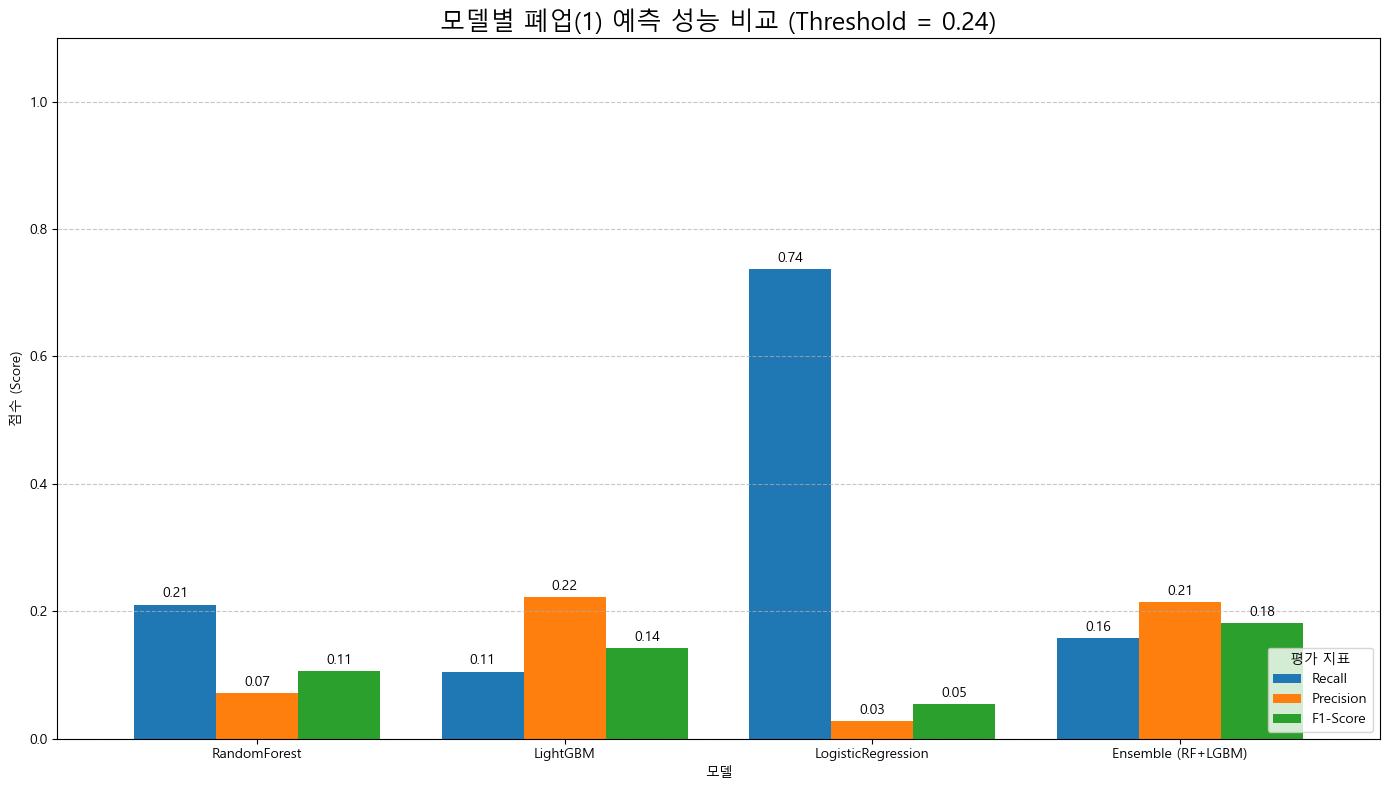

시각화 완료.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# -----------------------------------------------------------------------------
# 1. 모델별 파이프라인 정의 및 훈련
# -----------------------------------------------------------------------------
print("===== 1. 모델 파이프라인 정의 및 훈련 =====")

# 1-1. RandomForest
pipeline_rf = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# 1-2. LightGBM
pipeline_lgbm = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1))
])

# 1-3. LogisticRegression (비교군)
pipeline_lr = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1))
])

# 1-4. 앙상블 (Voting)
rf_for_ensemble = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
lgbm_for_ensemble = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)

voting_clf = VotingClassifier(
    estimators=[('rf', rf_for_ensemble), ('lgbm', lgbm_for_ensemble)],
    voting='soft'
)

pipeline_ensemble = ImbPipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', voting_clf)
])

# 전체 파이프라인 딕셔너리
pipelines = {
    "RandomForest": pipeline_rf,
    "LightGBM": pipeline_lgbm,
    "LogisticRegression": pipeline_lr,
    "Ensemble (RF+LGBM)": pipeline_ensemble
}

# 훈련 수행
for name, pipe in pipelines.items():
    print(f"Training {name}...")
    pipe.fit(X_train, y_train)

print("모든 모델 훈련 완료.")

# -----------------------------------------------------------------------------
# 2. 성능 평가 (최적 임계값 적용)
# -----------------------------------------------------------------------------
final_threshold = 0.24  # 탐색된 최적 임계값
results = {}

print(f"\n===== 2. 모델 성능 평가 (Threshold = {final_threshold:.2f}) =====")

for name, pipe in pipelines.items():
    # 확률 예측
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    
    # 임계값 적용
    y_pred_custom = (y_pred_proba >= final_threshold).astype(int)
    
    # 지표 계산
    recall = recall_score(y_test, y_pred_custom, pos_label=1, zero_division=0)
    precision = precision_score(y_test, y_pred_custom, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred_custom, pos_label=1, zero_division=0)
    
    results[name] = {'Recall': recall, 'Precision': precision, 'F1-Score': f1}
    print(f" - {name}: Recall={recall:.4f}, Precision={precision:.4f}, F1={f1:.4f}")

# 결과 집계
results_df = pd.DataFrame(results).T

# -----------------------------------------------------------------------------
# 3. 성능 비교 시각화 (개선된 방식)
# -----------------------------------------------------------------------------
print("\n===== 3. 성능 비교 시각화 =====")

# 막대 그래프 생성 (ax 객체 반환)
ax = results_df.plot(kind='bar', figsize=(14, 8), width=0.8, rot=0)

plt.title(f'모델별 폐업(1) 예측 성능 비교 (Threshold = {final_threshold:.2f})', fontsize=18)
plt.ylabel('점수 (Score)')
plt.xlabel('모델')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='평가 지표', loc='lower right')
plt.ylim(0, 1.1)  # y축 범위를 0~1.1로 고정하여 레이블 공간 확보

# 막대 위에 값 표시 (bar_label 활용)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

plt.tight_layout()
plt.show()

print("시각화 완료.")